<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel-Corrected90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import json
import zipfile
from io import BytesIO
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from IPython.display import Image, display_svg, SVG

import tensorflow as tf
import torch
import fastbook as fastai
fastai.setup_book()
from fastai import tabular
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
auth.authenticate_user()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [108]:
#filename = "train-data_all-train-events.zip"
#filename = "train-data-2022062020220626.zip"

#events-20-min includes reports for all trains in the a 2 week window reporting at most every 20 minutes 
#filename = "train-events-20-min.zip"

#Train reportings 15 minutes apart - everything we have collected
filename = "train-data-master.zip"

# miles answers the question "what spped will this train be moving in X miles (technically at milepost +/-X)"
#measurement = { 'unit' : 'miles', 'size' : 1.0 }

# minutes answers the question : what speed will this train be moving in X Minutes
#measurement = { 'unit' : 'minutes', 'size' : 30.0 }

#dep_var = 'nextSpeed'

# milepost answers the question "What milepost will this train be at in X Minutes"
measurement = { 'unit' : 'milepost', 'size' : 90.0 }

dep_var = 'nextValue'

#Determines the portion of data to train versus validate
dataCutpoint = .80

In [109]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-master.zip...
| [1 files][236.7 MiB/236.7 MiB]                                                
Operation completed over 1 objects/236.7 MiB.                                    


In [110]:
trains = {}
i = 1
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      print(i, " ", datetime.now().strftime("%H:%M:%S"))
                            

1000   21:26:19
2000   21:26:30
3000   21:26:38
4000   21:26:49
5000   21:26:54
6000   21:26:58
7000   21:27:02
8000   21:27:07
9000   21:27:18
10000   21:27:23
11000   21:27:27
12000   21:27:31
13000   21:27:36
14000   21:27:48
15000   21:27:52
16000   21:27:58
17000   21:28:03
18000   21:28:07
19000   21:28:11
20000   21:28:26
21000   21:28:30
22000   21:28:35
23000   21:28:39
24000   21:28:43
25000   21:28:48
26000   21:29:02
27000   21:29:06
28000   21:29:10
29000   21:29:15
30000   21:29:19
31000   21:29:24
32000   21:29:28
33000   21:29:43
34000   21:29:48
35000   21:29:52
36000   21:29:57
37000   21:30:01
38000   21:30:06


In [111]:
print(type(trains))
print(type(trains[1]))
trains[1]

<class 'dict'>
<class 'pandas.core.frame.DataFrame'>


,ptcLeadLocomotiveId,positionHistoryList,locomotiveList,subdivisionList,...,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,aotuTrainData.eventCode,aotuTrainData.routeLocationList
0,BNSF7601,"[{'positionTime': '2022-05-19T07:31:04Z', 'speedMPH': -12, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'EAST MAIN', 'milepost': {'milepostNumber': 766.9251}}}, {'positionTime': '2022-05-19T07:29:16Z', 'speedMPH': -12, 'milepostLocation': {'subdivisionId': 595, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 279.2352}}}, {'positionTime': '2022-05-19T07:28:44Z', 'speedMPH': -13, 'milepostLocation': {'subdivisionId': 595, 'trackName': 'MT 2', 'milepost': {'milepostNumber': 279.3427}}}, {'positionTime': '2022-05-19T07:28:09Z', 'speedMPH': -13, 'milepostLocation': {'subdivisionI...",[],"[{'subdivisionId': 595}, {'subdivisionId': 538}, {'subdivisionId': 605}, {'subdivisionId': 599}]",...,0,0,0,[]


In [112]:
dfTrainsAll = pd.concat(trains.values())

In [113]:
del trains

In [114]:
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

Filter out MP outside of Boone

In [115]:
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] < 327]
dfTrainsAll = dfTrainsAll[dfTrainsAll['milepost'] > 201]


In [116]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29770 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            29770 non-null  object 
 1   positionHistoryList                                            29770 non-null  object 
 2   locomotiveList                                                 29770 non-null  object 
 3   subdivisionList                                                29770 non-null  object 
 4   trainEstimatedPositionList                                     29770 non-null  object 
 5   trainActualPositionList                                        29770 non-null  object 
 6   trainId.trainSCAC                                              29728 non-null  object 
 7   trainId.trainSection                                          

# Create a learning set to modify

In [117]:
dfTrainsLearn = dfTrainsAll

Clear the nan values and replace with max values.

In [118]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)

Determine if the train is moving milepost Increasing or decreasing.

In [119]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

Make all speeds positive

In [120]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

Speed Distribution:


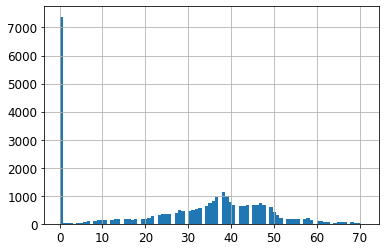

In [121]:
print("Speed Distribution:")
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

Replace the NaN values in AOTU with zeros

In [122]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

Categorize the applicable variables

In [123]:
def categorize(aDataFrame, columnName, defaultReplacement):
  aDataFrame[columnName] = aDataFrame[columnName].fillna(value=defaultReplacement)
  categories = aDataFrame[columnName].unique()
  print(aDataFrame[columnName].unique())
  aDataFrame[columnName] = aDataFrame[columnName].astype('category')
  aDataFrame[columnName] = aDataFrame[columnName].cat.set_categories(categories)
  return aDataFrame

In [124]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn = categorize(dfTrainsLearn, 'symbolType', "X")
dfTrainsLearn = categorize(dfTrainsLearn, 'lastReportedPosition.milepostLocation.trackName', "UNKNOWN")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSCAC',"UNK")
dfTrainsLearn = categorize(dfTrainsLearn, 'trainId.trainSection', ' ')
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.priorityCode', 0)  # may want to order these
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.categoryCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.authorityRangeCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.ownershipCode', 0)
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.tenantCarrier', "0")
dfTrainsLearn = categorize(dfTrainsLearn, 'aotuTrainData.eventCode', 0)
 

['M' 'U' 'E' 'G' 'C' 'A' 'I' 'W' 'Z' 'S' 'L' 'P']
['MT 1' 'MT 2' 'EASTXO' 'N SIDING' 'WESTXO' 'YD LD' '136' 'XO' '806' '405' '113']
['UP' 'UNK']
['' '2']
[4. 1. 3. 0.]
[12.  8. 15.  4.  2. 10. 19. 17. 11. 14.  0.]
[2. 1. 0.]
[2. 3. 0.]
['' 0.0]
[0.]


Replace unknown max speeds with 88 miles per hour (to make them recognizable)

In [125]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[60. 70. 50. 40. 88. 45. 79.  0. 30.]


Flatten out the work locations (we may want to change this for the NN algorithm)

In [126]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [127]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [128]:
dfTrainsLearn['workLocations'].unique()

array(['202.20', '258.40,202.20', None, '225.10', '202.20,258.40,321.50', '314.52,202.20', '321.50,202.20', '231.80,225.10', '214.50', '225.10,202.20', '202.20,258.40', '202.20,219.70',
       '219.70,202.20', '202.20,214.50,225.10,290.80,304.10', '202.20,258.40,225.10', '202.20,219.90,225.10', '202.20,257.60', '250.50,202.20', '268.40,202.20', '258.40,207.60,202.20',
       '207.60,202.20', '241.00,202.20', '258.40,219.70,202.20', '202.20,314.52', '202.92,202.20', '214.50,225.10,290.80,304.10,202.20', '290.80,258.40,231.80,202.20', '202.20,290.80',
       '202.20,299.75', '314.52,225.10,202.20', '202.20,219.70,277.50', '202.20,293.10', '202.20,304.10', '321.50,314.52,202.20', '202.20,240.90', '202.20,265.30', '265.30,202.20', '202.20,286.40',
       '240.90,207.60,202.20', '250.50,245.90,202.20', '219.70', '202.20,312.80', '321.50,240.90,202.20', '240.90,202.20', '202.20,207.60', '202.20,225.10', '326.20,214.50', '214.50,202.20',
       '240.90,214.50,202.20', '278.10,258.40,202.20', 

determine the locomotive count from the locomotive list.  We can make this more clever later, but for now this seems the most sensible shortcut

In [129]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

Convert the list of actual reportings into a dataframe.

In [130]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [131]:
def showTrain(idx):
  print(dfTrainsLearn.iloc[idx]['ptcLeadLocomotiveId'])
  print(dfTrainsLearn.iloc[idx]['trainId.trainSymbol'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.subdivisionId'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.trackName'])
  print(dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])

You can peer into the incoming data here:

In [132]:
idx = 1
showTrain(idx)
dfTrainsLearnActuals.iloc[idx]

NS1007
MGBNP
106
MT 1
209.8707


,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-09T19:40:07Z,0,106,MT 1,209.87070
1,2022-06-09T19:42:07Z,0,106,MT 1,209.87070
2,2022-06-09T19:44:07Z,5,106,MT 1,210.15358
3,2022-06-09T19:46:07Z,11,106,MT 1,210.46217
4,2022-06-09T19:48:07Z,17,106,MT 1,210.88560
...,...,...,...,...,...
52,2022-06-09T21:26:07Z,35,106,MT 1,281.16560
53,2022-06-09T21:28:07Z,42,106,MT 1,282.40717
54,2022-06-09T21:30:07Z,49,106,MT 1,283.95746
55,2022-06-09T21:34:07Z,62,106,MT 1,287.82657


In [133]:
dfTrainsBeop =  dfTrainsLearn[['lastReportedPosition.milepostLocation.milepost.milepostNumber','trainEstimatedPositionList']]
dfTrainsBeop

,lastReportedPosition.milepostLocation.milepost.milepostNumber,trainEstimatedPositionList
0,202.2072,"[{'positionTime': '2022-06-09T19:20:40Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 202.2072}}}, {'positionTime': '2022-06-09T19:22:40Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.70474}}}, {'positionTime': '2022-06-09T19:24:40Z', 'speedMPH': 49, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 205.29929}}}, {'positionTime': '2022-06-09T19:26:40Z', 'speedMPH': 53, 'milepostLocation': {'subdivisionId': 106..."
0,209.8707,[]
0,216.5130,"[{'positionTime': '2022-06-09T19:54:41Z', 'speedMPH': 26, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 216.513}}}, {'positionTime': '2022-06-09T19:56:41Z', 'speedMPH': 32, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 217.47511}}}, {'positionTime': '2022-06-09T19:58:41Z', 'speedMPH': 38, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 218.65654}}}, {'positionTime': '2022-06-09T20:00:41Z', 'speedMPH': 42, 'milepostLocation': {'subdivisionId': 106,..."
0,224.2101,"[{'positionTime': '2022-06-09T20:11:30Z', 'speedMPH': 31, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 224.2101}}}, {'positionTime': '2022-06-09T20:13:30Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 225.32594}}}, {'positionTime': '2022-06-09T20:15:30Z', 'speedMPH': 41, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 226.61711}}}, {'positionTime': '2022-06-09T20:17:30Z', 'speedMPH': 45, 'milepostLocation': {'subdivisionId': 106..."
0,235.8908,"[{'positionTime': '2022-06-09T20:27:41Z', 'speedMPH': 36, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 235.8908}}}, {'positionTime': '2022-06-09T20:29:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 237.54869}}}, {'positionTime': '2022-06-09T20:31:41Z', 'speedMPH': 40, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 238.9238}}}, {'positionTime': '2022-06-09T20:33:41Z', 'speedMPH': 44, 'milepostLocation': {'subdivisionId': 106,..."
...,...,...
0,217.0825,[]
0,215.1352,"[{'positionTime': '2022-06-04T01:18:01Z', 'speedMPH': -16, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 215.1352}}}, {'positionTime': '2022-06-04T01:20:01Z', 'speedMPH': -20, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 214.52847}}}, {'positionTime': '2022-06-04T01:22:01Z', 'speedMPH': -25, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 210.82147}}}, {'positionTime': '2022-06-04T01:24:01Z', 'speedMPH': -28, 'milepostLocation': {'subdivisionId':..."
0,207.0881,[]
0,207.0909,[]


Renumber the list

In [134]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

# Determine NextValue
This will be the value we are attempting to learn

In [135]:
def findEntryAtTime(actualsEntry, timeInMinutes):
  idx = math.trunc(timeInMinutes // 2)
  if (idx < len(actualsEntry)):
    return actualsEntry.iloc[idx]
  return pd.Series()

In [136]:
def findNextTime(trainsEntry, actualsEntry, timeInMinutes):
  entry = findEntryAtTime(actualsEntry, timeInMinutes)
  if (entry.empty):
    return None
  return (abs(entry['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))

In [137]:
def findNextMilepost(trainsEntry, actualsEntry, distance):
  currMilepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > currMilepost + distance]
  if (len(value) > 0) :
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].min()]
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < currMilepost - distance]
  if (len(value) > 0):
    return value[value['milepostLocation.milepost.milepostNumber'] == value['milepostLocation.milepost.milepostNumber'].max()]
  return []

In [138]:
def findNextMilepostAtTime(actualsEntry, timeInMinutes):
  entry = findEntryAtTime(actualsEntry, timeInMinutes)
  if (entry.empty):
    return None
  return entry['milepostLocation.milepost.milepostNumber']  

In [139]:
def findNextSpeed(trainsEntry, actualsEntry):
  if (measurement.get('unit') == 'miles'):
    nextActual = findNextMilepost(trainsEntry, actualsEntry, measurement.get('size'))
    if (nextActual != None and len(nextActual) > 0):
      amt = (abs(nextActual.iloc[0]['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
      return amt;
  elif (measurement.get('unit') == 'minutes'):
    return findNextTime(trainsEntry, actualsEntry, measurement.get('size'))
  elif (measurement.get('unit') == 'milepost'):
    return findNextMilepostAtTime(actualsEntry, measurement.get('size'))
  else:
    raise Exception('unknown measurement', measurement.get('unit'))    
  return None

You can peer into the mechanics of a lookup here:

In [140]:
beopJSON = dfTrainsBeop.iloc[3291]['trainEstimatedPositionList']
beopDT = pd.json_normalize(beopJSON)
print(beopDT)

            positionTime  speedMPH  milepostLocation.subdivisionId  \
0   2022-05-11T10:25:35Z        39                             106   
1   2022-05-11T10:27:35Z        40                             106   
2   2022-05-11T10:29:35Z        40                             106   
3   2022-05-11T10:31:35Z        40                             106   
4   2022-05-11T10:33:35Z        48                             106   
..                   ...       ...                             ...   
56  2022-05-11T12:17:35Z        50                             106   
57  2022-05-11T12:19:35Z        50                             106   
58  2022-05-11T12:21:35Z        50                             106   
59  2022-05-11T12:23:35Z        50                             106   
60  2022-05-11T12:25:35Z        50                             106   

   milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
0                        MT 2                                 320.46980  
1          

In [141]:
dfTrainsLearnActuals.iloc[3291]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-05-11T10:27:35Z,38,106,MT 2,321.73276
1,2022-05-11T10:29:35Z,37,106,MT 2,322.98834
2,2022-05-11T10:31:35Z,31,106,MT 2,324.09690
3,2022-05-11T10:33:35Z,22,106,MT 2,325.04443
4,2022-05-11T10:35:35Z,5,106,MT 2,325.57175
...,...,...,...,...,...
39,2022-05-11T11:45:35Z,0,106,MT 2,325.69920
40,2022-05-11T11:47:35Z,0,106,MT 2,325.69900
41,2022-05-11T11:49:35Z,0,106,MT 2,325.69900
42,2022-05-11T11:51:35Z,2,106,MT 2,325.77545


In [142]:
idx = 3291
distMI = 10
timeMin = 15  
showTrain(idx)
print("Reported speed: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.speedMPH'])
print("Reported MP: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.milepostLocation.milepost.milepostNumber'])
print("Reported Time: ", dfTrainsLearn.iloc[idx]['lastReportedPosition.positionTime'])

nextActual = findNextMilepost(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx], distMI)
print("Next Entry in ",distMI," Miles: \n",nextActual)
nextActual = findEntryAtTime(dfTrainsLearnActuals.iloc[idx], timeMin)
print("Entry in ",timeMin," Min: ",nextActual)
nextActual = findNextMilepostAtTime(dfTrainsLearnActuals.iloc[idx], timeMin)
print("Milepost in ",timeMin," Min: ",nextActual)

print("actual Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], dfTrainsLearnActuals.iloc[idx]))
beopJSON = dfTrainsBeop.iloc[idx]['trainEstimatedPositionList']
if not type(beopJSON) is float and len(beopJSON) > 0:
  beopDT = pd.json_normalize(beopJSON)
  nextBeop = findNextMilepost(dfTrainsLearn.iloc[idx], beopDT, distMI)
  print("Next Beop in ",distMI," miles: \n",nextBeop)
  nextBeop = findEntryAtTime(beopDT, timeMin)
  print("Beop in ",timeMin," Min: ",nextBeop)
  print(type(nextBeop))
  print("beop Value: ", findNextSpeed(dfTrainsLearn.iloc[idx], beopDT))

UP2706
MCHCB
106
MT 2
320.4698
Reported speed:  39
Reported MP:  320.4698
Reported Time:  2022-05-11T10:25:35Z
Next Entry in  10  Miles: 
 []
Entry in  15  Min:  positionTime                                2022-05-11T10:41:35Z
speedMPH                                                       0
milepostLocation.subdivisionId                               106
milepostLocation.trackName                                  MT 2
milepostLocation.milepost.milepostNumber                 325.699
Name: 7, dtype: object
Milepost in  15  Min:  325.699
actual Value:  None
Next Beop in  10  miles: 
            positionTime  speedMPH  milepostLocation.subdivisionId  \
7  2022-05-11T10:39:35Z        50                             106   

  milepostLocation.trackName  milepostLocation.milepost.milepostNumber  
7                       MT 2                                 330.95325  
Beop in  15  Min:  positionTime                                2022-05-11T10:39:35Z
speedMPH                                   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


Run the calulations.  This will take a moment.

In [143]:
dfTrainsLearn['nextValue'] = np.NaN
dfTrainsLearn['beopValue'] = np.NaN
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  nextValue = findNextSpeed(trainsEntry, dfTrainsLearnActuals.iloc[i])
  if (nextValue != None):
    dfTrainsLearn.at[i,'nextValue'] = nextValue
  beopJSON = dfTrainsBeop.iloc[i]['trainEstimatedPositionList']
  if not type(beopJSON) is float and len(beopJSON) > 0:
    try:
      beopDT = pd.json_normalize(beopJSON)
      if (measurement.get('unit') == 'miles'):
        nextBeop = findNextMilepost(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'minutes'):
        nextBeop = findNextTime(trainsEntry, beopDT, measurement.get('size'))
      elif (measurement.get('unit') == 'milepost'):
        nextBeop = findNextMilepostAtTime(beopDT, measurement.get('size'))
      if (nextBeop != None):
        dfTrainsLearn.at[i,'beopValue'] = nextBeop
    except NotImplementedError:
      print(type(beopJSON))
    except KeyError:
      print(beopJSON)
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [144]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['nextValue'])
dfTrainsLearn['nextValue'].unique()

array([254.19156, 268.71686, 281.51736, ..., 217.0825 , 209.24693, 206.47125])

NextValue values histogram:


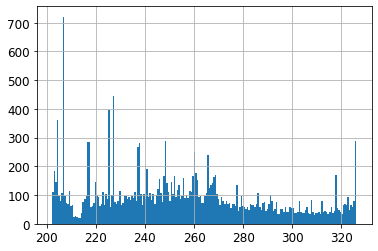

In [145]:
print("NextValue values histogram:")
dfTrainsLearn['nextValue'].hist(bins=200)

In [146]:
dfTrainsLearn['beopValue'].unique()

array([287.96326,       nan, 298.9823 , ..., 175.4504 , 166.35724, 156.57187])

physics predictions histogram:


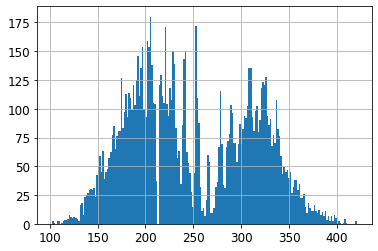

In [147]:
print("physics predictions histogram:")
dfTrainsLearn['beopValue'].hist(bins=200)

In [148]:
dfTrainsNextBeop = dfTrainsLearn['beopValue']

Drop some values we are not using at the moment, not needed.

Note, this will disable above computations unless you resume at "Create a learning set"

In [149]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'beopValue',
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

Burst dates into subcolumns that might prove useful

In [150]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,NS1007,UP,,MGBNP,...,False,False,False,1.654802e+09
1,NS1007,UP,,MGBNP,...,False,False,False,1.654803e+09
2,NS1007,UP,,MGBNP,...,False,False,False,1.654804e+09
3,NS1007,UP,,MGBNP,...,False,False,False,1.654805e+09
4,NS1007,UP,,MGBNP,...,False,False,False,1.654806e+09
...,...,...,...,...,...,...,...,...,...
29760,UP7942,UP,,MNPCH,...,False,False,False,1.654299e+09
29761,UP7942,UP,,MNPCH,...,False,False,False,1.654300e+09
29762,UP7942,UP,,MNPCH,...,False,False,False,1.654301e+09
29763,UP7942,UP,,MNPCH,...,False,False,False,1.654302e+09


In [151]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[10])

(19073, 47)
(29770,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19073 entries, 0 to 29764
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            19073 non-null  object        
 1   trainId.trainSCAC                                              19073 non-null  category      
 2   trainId.trainSection                                           19073 non-null  category      
 3   trainId.trainSymbol                                            19073 non-null  object        
 4   trainId.trainDate                                              19073 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  19073 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            19073 non-

# Use Decision Tree to predict next value

In [152]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

Breakdown the data by day of year - we will train with older data and then test the model with newer values.
Note: this simple logic will fail at the begining of a new year!

In [153]:
dateValues = dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count()
print(dateValues)

lastReportedPosition.positionTimeDayofyear
90      46
91     149
92     155
93     147
94      73
      ... 
183    234
184    170
185    175
186    181
187    317
Name: lastReportedPosition.positionTimeDayofyear, Length: 97, dtype: int64


In [154]:
print("We will partition this set at day of year:", dateValues.index[math.trunc(dateValues.size * dataCutpoint)])

We will partition this set at day of year: 167


In [155]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] <= dateValues.index[math.trunc(dateValues.size * dataCutpoint)] )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [156]:
#dep_var = 'nextSpeed'

In [157]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [158]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

Length of Training And Validation Sets:

In [159]:
trainingLength = len(to.train)
validationLength= len(to.valid)
trainingLength, validationLength

(15453, 3620)

In [160]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.eventCode,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextValue
0,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,42,202.207199,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,60.0,102.0,0.0,9738.0,7158.0,202,2,6,23,9,3,160,1.654802e+09,254.191559
1,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,0,209.870697,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,209,2,6,23,9,3,160,1.654803e+09,268.716858
2,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,26,216.513000,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,216,2,6,23,9,3,160,1.654804e+09,281.517365
3,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,31,224.210098,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,224,2,6,23,9,3,160,1.654806e+09,298.183258
4,NS1007,UP,,MGBNP,2022-06-08,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,36,235.890793,143058000.0,1148000.0,8640000.0,17820.0,65535.0,0.0,0.0,0.0,0.0,70.0,102.0,0.0,9738.0,7158.0,235,2,6,23,9,3,160,1.654806e+09,315.875427
31,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,33,202.206802,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,202,4,6,22,4,5,155,1.654303e+09,268.188629
32,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,54,220.706604,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,220,4,6,22,4,5,155,1.654304e+09,284.669617
33,NS4141,UP,,MGBNP,2022-06-02,106,MT 2,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,39,231.671707,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,231,4,6,22,4,5,155,1.654305e+09,296.118042
34,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,17,238.139694,152058000.0,1193280.0,17240000.0,35220.0,65535.0,0.0,0.0,0.0,0.0,70.0,106.0,0.0,10261.0,7619.0,238,4,6,22,4,5,155,1.654306e+09,309.762787
35,NS4141,UP,,MGBNP,2022-06-02,106,MT 1,4.0,12.0,2.0,2.0,0.0,True,M,202.20,2022,False,False,False,False,False,False,61,246.636902,152058000.0,1193280.0,17240000.0,35220.0,65535

# Measure the Physics BEoP Root Mean Standard Error (RMSE) on Validation Set

In [161]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [162]:
def showPredictions(predictionsSeries, validSeries):
  b = predictionsSeries.reset_index(drop=true)
  y = validSeries.reset_index(drop=true)
  
  df  = pd.concat([b, y], axis=1)
  df = df.dropna()
  df = df.rename(columns={ df.columns[0]: "prediction", df.columns[1]: "actual" })
  df['delta'] = abs(df["prediction"] - df["actual"])
  print(df)
  colors = np.where(df["delta"]<=5, '#1e0f24', '#bfa91b')
  ax1 = df.plot.scatter(x='prediction',y='actual', c = colors,  figsize=(20,10))
  print("RMSE: ", r_mse(df.iloc[:,0], df.iloc[:,1]))

      prediction     actual     delta
0      228.90681  273.95697  45.05016
1      216.49052  266.38187  49.89135
2      201.33698  253.75940  52.42242
4      191.95648  225.55972  33.60324
5      180.94266  217.96088  37.01822
...          ...        ...       ...
3615   185.29308  217.08250  31.78942
3616   177.55142  209.24693  31.69551
3617   175.45040  207.08810  31.63770
3618   166.35724  207.08860  40.73136
3619   156.57187  206.47125  49.89938

[2070 rows x 3 columns]
RMSE:  40.284772


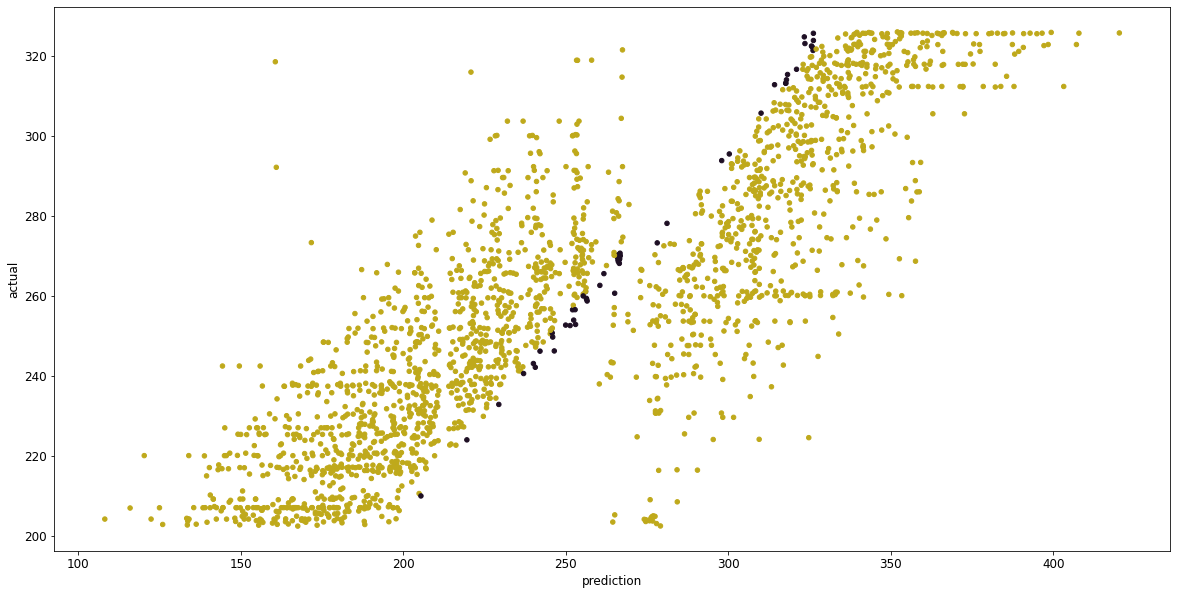

In [163]:
dfTrainsNextActual = dfTrainsLearn['nextValue']
showPredictions(dfTrainsNextBeop.tail(validationLength), dfTrainsNextActual.tail(validationLength))

In [164]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating a Decision Tree

In [165]:
to = fastai.load_pickle('/tmp/to.pkl')

In [166]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [167]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

Here is a sample of a Decision Tree with just 16 nodes:

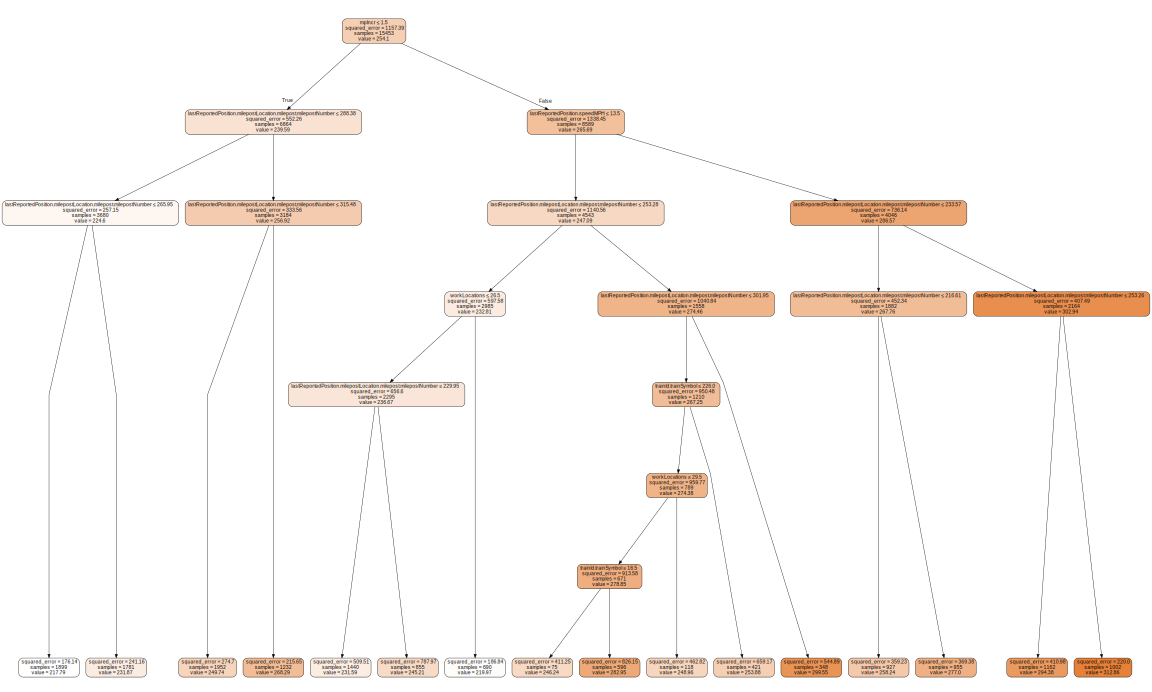

In [168]:
fastai.draw_tree(m, xs, size=16, leaves_parallel=True, precision=2)

In [169]:
m = DecisionTreeRegressor(min_samples_leaf=9)
m.fit(xs, y);

Root Mean Standard Error (RMSE)

How well we fit the training model:

In [170]:
trainingPreds = m.predict(xs)
r_mse(trainingPreds, y)

10.644845

How well we fit the Validation Model:

In [171]:
validationPreds = m.predict(valid_xs)
r_mse(validationPreds, valid_y)

18.745163

Simple Decision Tree Predictions:

      prediction      actual      delta
0     277.905243  283.894257   5.989014
1     255.961886  276.151855  20.189969
2     260.113116  268.870575   8.757458
3     262.586960  283.237732  20.650772
4     269.195571  296.864929  27.669358
...          ...         ...        ...
3615  217.791255  235.654480  17.863225
3616  217.791255  226.629501   8.838247
3617  226.454239  220.771225   5.683014
3618  219.815933  216.747055   3.068878
3619  216.153210  209.393463   6.759747

[3620 rows x 3 columns]
RMSE:  18.745163


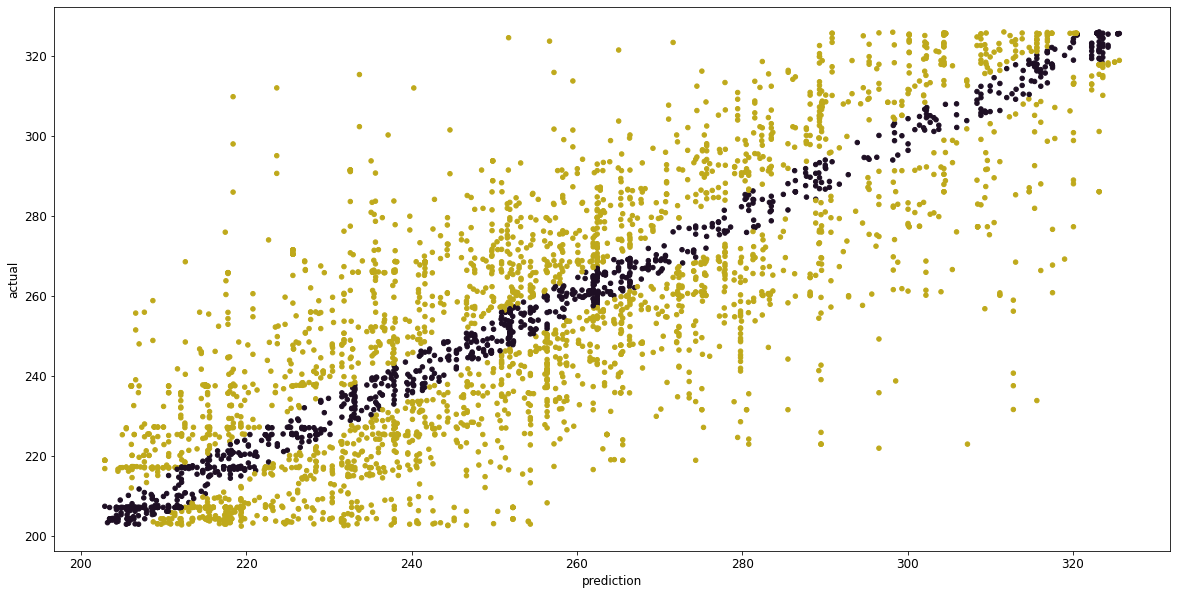

In [172]:
showPredictions(pd.DataFrame(validationPreds), valid_y)

In [173]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [174]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.410814
22,lastReportedPosition.speedMPH,0.219652
12,mpIncr,0.161057
3,trainId.trainSymbol,0.055348
14,workLocations,0.028670
34,loadedCarCount,0.010485
36,trainLength,0.010219
42,lastReportedPosition.positionTimeDay,0.008930
26,aotuTrainData.totalLocomotiveWeight,0.008263
29,aotuTrainData.heavy143TonCarCount,0.007860


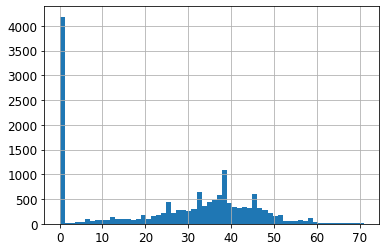

In [175]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


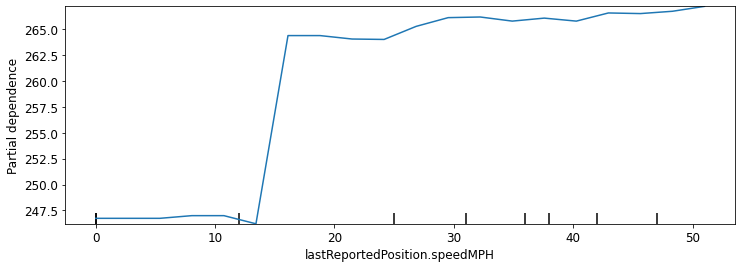

In [176]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

#Random Forest

In [177]:
def randomForest(xs, y, n_estimators=50, max_samples=10000,
       max_features=0.7, min_samples_leaf=7, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [178]:
m = randomForest(xs, y);

In [179]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(10.876987, 15.650574)

In [180]:
%%capture log
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Random Forest Predictions:

      prediction      actual      delta
0     271.475304  283.894257  12.418953
1     257.007452  276.151855  19.144404
2     262.783639  268.870575   6.086936
3     261.318942  283.237732  21.918790
4     268.058689  296.864929  28.806240
...          ...         ...        ...
3615  229.264393  235.654480   6.390087
3616  229.264393  226.629501   2.634891
3617  227.593465  220.771225   6.822240
3618  223.157541  216.747055   6.410486
3619  221.107909  209.393463  11.714446

[3620 rows x 3 columns]
RMSE:  15.650574


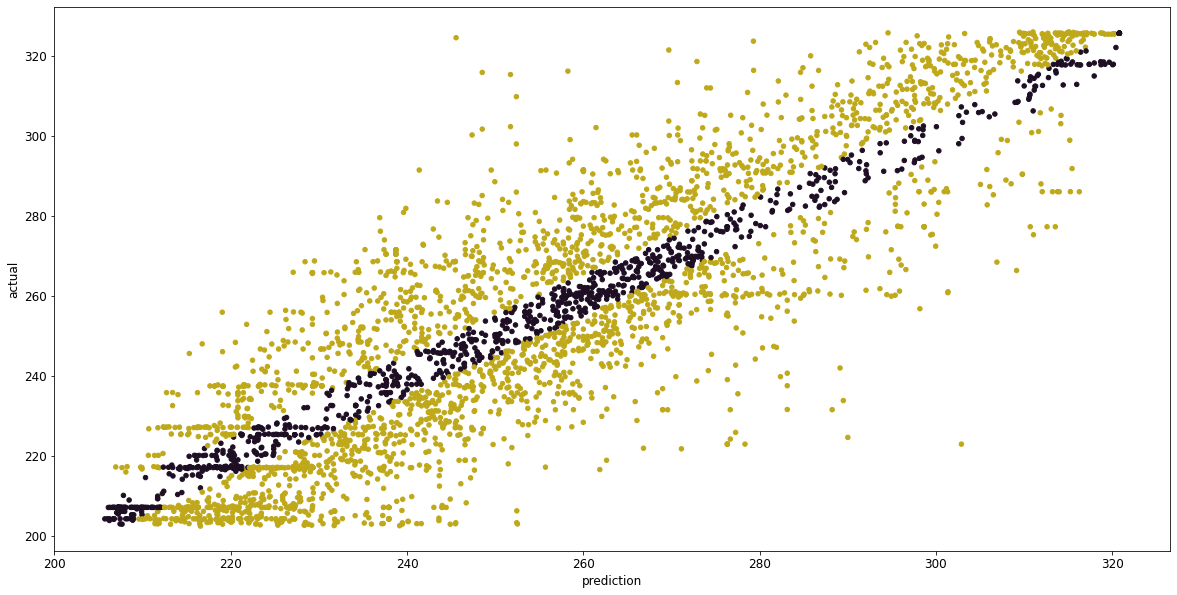

In [181]:
showPredictions(pd.DataFrame(preds.mean(0)), valid_y)


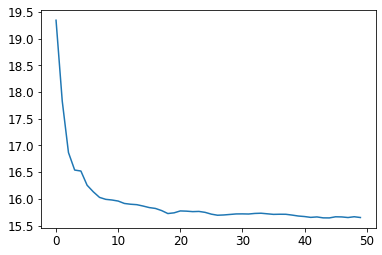

In [182]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

#Further Technical Inspections
Some checks for out-of-bag errors, etc.

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [183]:
r_mse(m.oob_prediction_, y)

13.603795

In [184]:
%%capture log
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [185]:
preds.shape

(50, 3620)

We can get the standard deviation of the predictions over all the trees, for each train:

In [186]:
preds_std = preds.std(0)

Standard Deviation for the predictions of the first 5 trains:


In [187]:
preds_std[:5]

array([ 8.99676817,  7.27928928, 10.09038943,  9.12397674, 10.59678641])

# FEATURE Importance

In [188]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
23,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.285561
22,lastReportedPosition.speedMPH,0.208432
12,mpIncr,0.187187
38,milepost,0.099164
14,workLocations,0.040620
3,trainId.trainSymbol,0.040399
35,emptyCarCount,0.010266
34,loadedCarCount,0.009949
33,maximumTrainSpeed,0.009379
0,ptcLeadLocomotiveId,0.008716


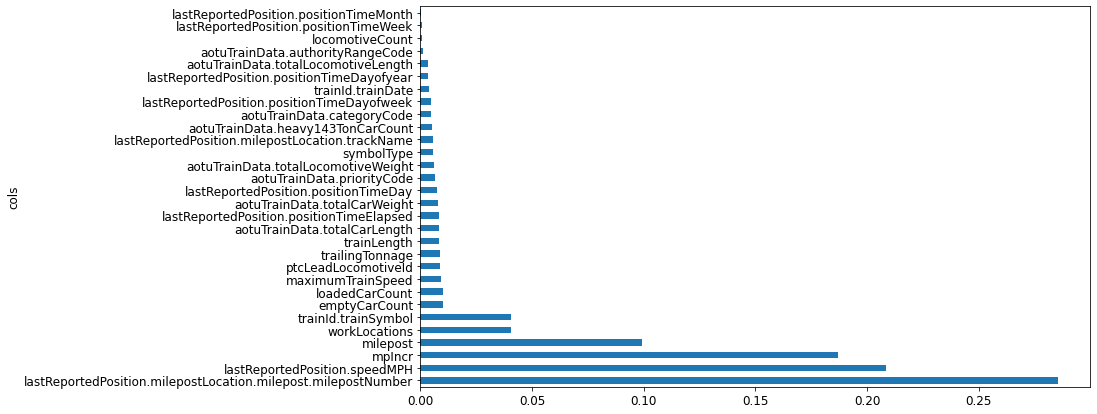

In [189]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [190]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

30

In [191]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [192]:
m = randomForest(xs_imp, y)

In [193]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(10.807709, 15.567258)

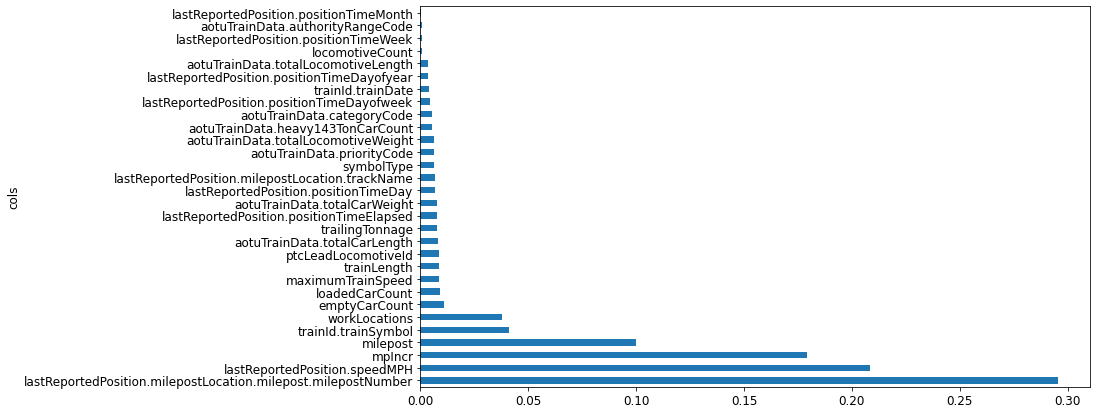

In [194]:
plot_fi(rf_feat_importance(m, xs_imp));

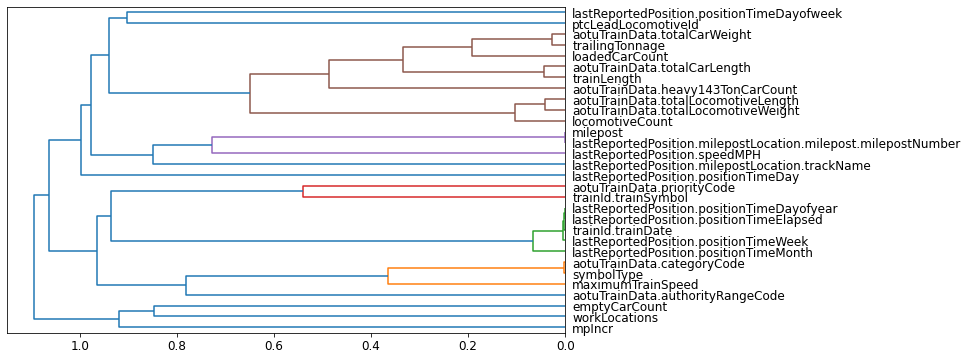

In [195]:
fastai.cluster_columns(xs_imp)

# Compute the Physics Model loss for the same interval:

In [196]:
# showPredictions(dfTrainsNextBeop.tail(len(valid_y)), valid_y)

In [197]:
dfTrainsNextBeop

0        287.96326
1              NaN
2        298.98230
3        308.50950
4        324.24740
           ...    
29760    185.29308
29761    177.55142
29762    175.45040
29763    166.35724
29764    156.57187
Name: beopValue, Length: 19073, dtype: float64

# Finding Out-of-Domain Data
Spot variables that are unique to the test set versus the training set

In [198]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

m = randomForest(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:8]

,cols,imp
44,lastReportedPosition.positionTimeDayofyear,0.464919
45,lastReportedPosition.positionTimeElapsed,0.459913
4,trainId.trainDate,0.051099
41,lastReportedPosition.positionTimeWeek,0.016274
40,lastReportedPosition.positionTimeMonth,0.007601
42,lastReportedPosition.positionTimeDay,0.000195
33,maximumTrainSpeed,0.000000
26,aotuTrainData.totalLocomotiveWeight,0.000000


Consider whether these values make sense

#Using a Neural Net

In [199]:
df_nn_final = dfTrainsLearn

In [200]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19073 entries, 0 to 29764
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            19073 non-null  object        
 1   trainId.trainSCAC                                              19073 non-null  category      
 2   trainId.trainSection                                           19073 non-null  category      
 3   trainId.trainSymbol                                            19073 non-null  object        
 4   trainId.trainDate                                              19073 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  19073 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            19073 non-null  int64         


In [201]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [202]:
cont_nn

['lastReportedPosition.milepostLocation.milepost.milepostNumber',
 'aotuTrainData.totalCarWeight',
 'aotuTrainData.totalCarLength',
 'aotuTrainData.totalLocomotiveWeight',
 'aotuTrainData.totalLocomotiveLength',
 'aotuTrainData.actualTonsPerAxle',
 'aotuTrainData.heavy143TonCarCount',
 'aotuTrainData.heavy158TonCarCount',
 'aotuTrainData.over158TonCarCount',
 'aotuTrainData.highWideCarCount',
 'maximumTrainSpeed',
 'loadedCarCount',
 'emptyCarCount',
 'trainLength',
 'trailingTonnage',
 'lastReportedPosition.positionTimeElapsed']

In [203]:
numUniquePerCat = df_nn_final[cat_nn].nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(numUniquePerCat)

ptcLeadLocomotiveId                                    999
trainId.trainSCAC                                        2
trainId.trainSection                                     2
trainId.trainSymbol                                    306
trainId.trainDate                                      102
lastReportedPosition.speedMPH                           72
lastReportedPosition.milepostLocation.subdivisionId      1
lastReportedPosition.milepostLocation.trackName         11
aotuTrainData.priorityCode                               3
aotuTrainData.categoryCode                              10
aotuTrainData.authorityRangeCode                         2
aotuTrainData.ownershipCode                              2
aotuTrainData.eventCode                                  1
milepost                                               123
mpIncr                                                   2
symbolType                                              12
workLocations                                           

In [204]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [205]:
dls = to_nn.dataloaders(1024)

In [206]:
y = to_nn.train.y
y.min(),y.max()

(202.2161, 326.0917)

In [207]:
linearLayers=500
activations=250
learn = tabular_learner(dls, y_range=(202,327), layers=[linearLayers,activations],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0005754399462603033)

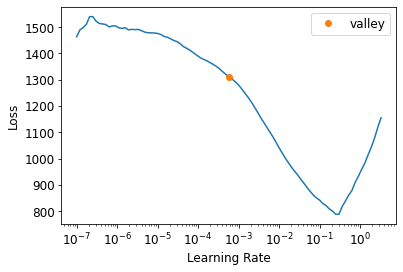

In [208]:
learn.lr_find()

In [209]:
# Default NN 
# learn.fit_one_cycle(50, 1e-4)

In [210]:
#"Ranger" Optimizer Uses Pytorch’s CosineAnnealing
learn.fit_flat_cos(20, 1e-4)

epoch,train_loss,valid_loss,time
0,1150.371216,6466.741211,00:01
1,1023.826721,6466.741211,00:01
2,915.187988,6466.741211,00:01
3,801.845032,6466.741211,00:01
4,691.498596,6466.741211,00:01
5,587.089966,6466.741211,00:01
6,500.521088,6466.739258,00:01
7,427.258575,6387.544922,00:01
8,367.537292,4490.261230,00:01
9,323.245026,3386.379883,00:01


In [211]:
# Stochastic Gradient Descent
# Too Much Ram -  cannot run here 
# learn.fit_sgdr(31, 10)

NN Predictions:

      prediction      actual       delta
0     324.942657  283.894257   41.048401
1     324.611389  276.151855   48.459534
2     321.992554  268.870575   53.121979
3     324.124573  283.237732   40.886841
4     325.022461  296.864929   28.157532
...          ...         ...         ...
3615  323.212219  235.654480   87.557739
3616  323.212372  226.629501   96.582870
3617  322.103760  220.771225  101.332535
3618  320.557831  216.747055  103.810776
3619  320.742279  209.393463  111.348816

[3620 rows x 3 columns]
RMSE:  68.030507


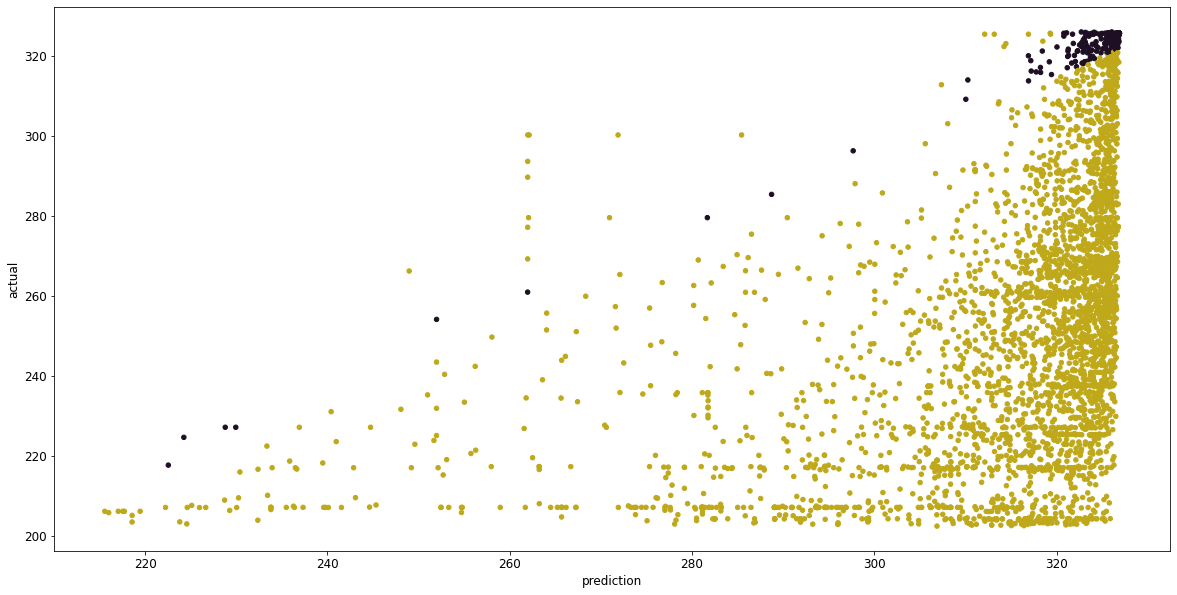

In [212]:
preds,targs = learn.get_preds()
showPredictions(pd.DataFrame(preds.numpy(), columns=['prediction']), 
                pd.DataFrame(targs.numpy(), columns=['actual']))